[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NiCALab-IMAL/coadpative_BOTDA/blob/main/H3_BadTraining.ipynb)

#Co-adaptive BCI based on supervised domain adaptation: results in motor imagery simulated data

Notebook credits: Valeria Spagnolo, Catalina Galván, [Victoria Peterson](https://sites.google.com/view/victoria-peterson/home)

Laboratorio de Neuroingeniería Computacional Aplicada, Instituto de Matemática Aplicada del Litoral, IMAL, UNL-CONICET
https://sites.google.com/view/nicalab



### Demo for testing main hypothesis: “In supervised online adaptation based on BOTDA, the associated cost of transporting a testing trial to match the calibration data distribution reflects the MI user self-regulation capability.”

In [23]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Install and import the necessary libraries

In [24]:
!pip install wget
!pip install mne
!pip install POT
!pip install pyriemann
!git clone https://github.com/vpeterson/otda-mibci.git

fatal: destination path 'otda-mibci' already exists and is not an empty directory.


In [25]:
import wget
import numpy as np
import sys
import os
import random
from random import sample
import matplotlib.pyplot as plt
import seaborn as sb
import mne
from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.classification import class_distinctiveness
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

sys.path.append('otda-mibci')
from MIOTDAfunctions import SelectSubsetTraining_BOTDAl1l2
from BOTDA import BOTDA

mne.set_log_level(verbose='warning') # to avoid info at terminal

random.seed(42)


## Part 1: Algorithmic support correlation with ERD discriminability


## Load and prepare data


### Calibration session

For this demo to ensure a perfect calibration session simulated data at which all trials are aligned to their corresponding class and have ERD% = 50 is used ($S_{50,0}$) for calibration purposes (model training).

In [26]:
wget.download("https://zenodo.org/records/13760210/files/S_50_epo.fif?download=1",
              out="S_50_epo.fif")
epochs_train = mne.read_epochs("S_50_epo.fif", preload=True, verbose=False)
# Resample to 250 Hz
epochs_train = epochs_train.resample(250)
epochs_train_array = epochs_train.get_data()  # Epoched data as a numpy array
# Band-pass filter
epochs_train_array=mne.filter.filter_data(epochs_train_array, 250, 8, 30)

### Application session



To understand whether a correlation exists in between the algorithmic support and the simulated self-regulation capability, the application session is defined by a session at which trials have ERD% values uniformly distribuited from 10 to 50%

In [27]:
wget.download("https://zenodo.org/records/13760210/files/S_mix_epo.fif?download=1",
              out="S_mix_epo.fif")
epochs_test = mne.read_epochs("S_mix_epo.fif", preload=True, verbose=False)
# Resample to 250 Hz
epochs_test = epochs_test.resample(250)
epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
# Band-pass filter
epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)

Load ERD list info


In [28]:
wget.download("https://zenodo.org/records/13760210/files/S_mix_ERD_list.npy?download=1",
              out="S_mix_ERD_list.npy")
ERDS = np.load('S_mix_ERD_list.npy')


Plot ERD distribution

Text(0.5, 1.0, 'ERD data distribution')

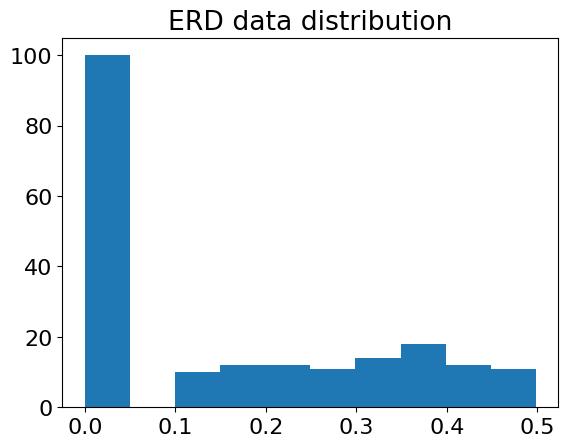

In [29]:
plt.hist(ERDS);
plt.title("ERD data distribution")

Here we see that half of the trials have ERD% equal to 0 while the other half have ERD% values distributed between 0.1 and 0.5

## Model training

As decoding model the typical CSP + LDA is used. Here, given that we know the way simulated data was created, only two components are extracted from CSP

### Define training data

In [30]:
Xtr = epochs_train_array
Ytr = epochs_train.events[:,2]

### Fit the model

In [31]:
# Create CSP and LDA objects
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
lda = LinearDiscriminantAnalysis()
# Learn CSP filters and get the CSP features
Gtr = csp.fit_transform(Xtr, Ytr)
# Fit LDA
lda.fit(Gtr, Ytr);


(-3.0561077951289985, 0.5683961773250759)

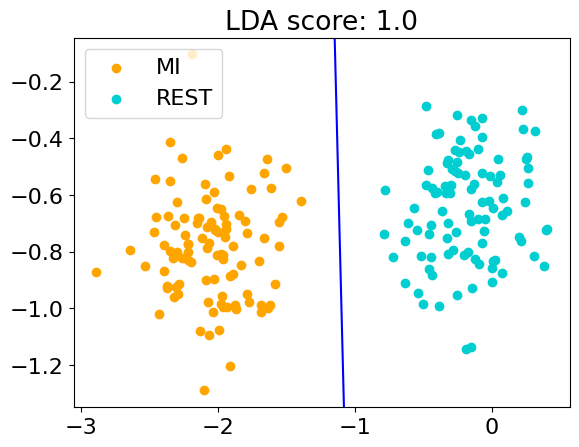

In [32]:

# Get the accuracy at training data
acc_tr = lda.score(Gtr, Ytr)

# Plot first 2 CSP features of the training set + the LDA decision boundary
features = Gtr[:,0:2]
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("LDA score: " + str(lda.score(Gtr,Ytr)))
axs.legend()
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.set_xlim(xlim)

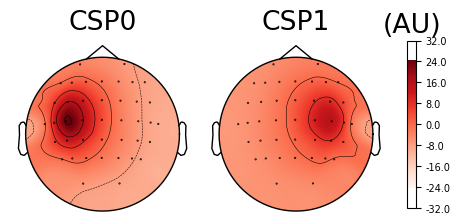

In [33]:
# Plot CSP patterns
fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='(AU)', size=1.5, cmap='Reds')

## Online model evaluation without BOTDA


### Define recalibration and testing data

Recalibration data is simulated as the first 20 trials of the application session, while the remaining trials define the testing data.



In [34]:
Xte = epochs_test_array[20:].copy()  # Epoched data as a numpy array
Yte = epochs_test.events[20:,2].copy()
# use the first 20 samples for validation
Xval = epochs_test_array[:20].copy()  # Epoched data as a numpy array
Yval = epochs_test.events[:20,2].copy()

### Evaluate the model

In [35]:
# Calculate testing and validation CSP features
Gte = csp.transform(Xte)
Gval = csp.transform(Xval)

# Predict the testing classes using LDA and calculate testing accuracy
y_predict_lda = lda.predict(Gte)
acc_lda = (accuracy_score(Yte, y_predict_lda))

# Print testing LDA accuracy
print('Testing accuracy LDA (without BOTDA): ' + str(round(acc_lda, 3)))

Testing accuracy LDA (without BOTDA): 0.856


## Online model evaluation with BOTDA

### Define BOTDA parameters

In [36]:
# here regularization parameters are given
rango_e = [1]
rango_cl = [0.1]
metric = "sqeuclidean"
outerkfold =20
innerkfold = None
M = 20
norm = "max"

In [37]:
y_predict_ot = []  # Initialize list to store predicted classes
Transp = []   # Initialize list to store transported features
algorithm_support = []  # Initialize list to store the transport cost values

# Select source subset based on CV and validation features
G_botdatr, Y_botdatr, reg_botda=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)
# Create BOTDA object
botda = BOTDA(reg_botda, lda, metric)

# For each testing trial
for re in range(0, len(Yte)):
    # Testing trial
    Xte_ = Xte[re:re+1]
    Yte_ = Yte[re:re+1]

    # Append to the Xval subset the current testing trial
    Xval_ = np.vstack((Xval.copy(), Xte_))
    Yval_ = np.hstack((Yval.copy(), Yte_))

    # Calculate validation and testing CSP features
    Gval_ = csp.transform(Xval_)
    Gte_ = csp.transform(Xte_)

    # Learn the transport based on the selected source subset and the current validation subset
    botda.fit(G_botdatr, Gval_, Yval_)
    # Transport testing feature and predict its class
    Gte_transported, y_pred_ = botda.transform(Gte_)
    Transp.append(Gte_transported)
    y_predict_ot.append(y_pred_)
    # Calculate the transport cost
    botda_matrix = botda.coupling_
    distance_ot = botda.cost_
    algorithm_support.append(botda_matrix[-1, :] @ distance_ot[-1,:])

Gte_ot = np.squeeze(Transp)
y_predict_ot = np.squeeze(y_predict_ot)

# Calculate accuracy
acc_OT = accuracy_score(Yte,y_predict_ot)
print('Testing accuracy LDA + BOTDA: ' + str(round(acc_OT, 3)))

Testing accuracy LDA + BOTDA: 0.917


### Plotting the results

-0.7999233852018783 6.824617744240645e-22


Text(0.05, 0.95, 'r = -0.80\np = 0.0000')

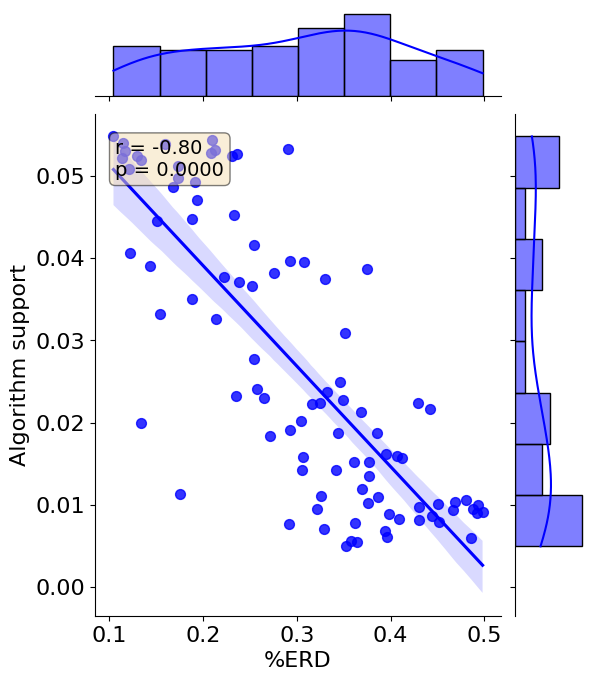

In [38]:
# select the ERD values for the testing data
ERDS_test = ERDS[20:]
ERDS_test[ERDS_test==0]=None #To avoid neg. class
coupling = np.squeeze(np.asarray(algorithm_support))

#only positive class
plt.rcParams.update({'font.size': 16})
x=ERDS_test[Yte==1]
y=coupling[Yte==1]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value, p_value)
sb.jointplot(data=None, x=x, y=y, kind="reg", color="b", height=7, scatter_kws={"s": 50})
plt.xlabel("%ERD", fontsize=16)
plt.ylabel("Algorithm support", fontsize=16)
plt.subplots_adjust(left=0.2, right=0.9, bottom=0.1)
# add text box with r and p values
textstr = f"r = {r_value:.2f}\np = {p_value:.4f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# Part 2: Algorithmic support with increasing mental fatigue



While training data remains the same, here we use as for model evaluation a simualted data with increasing fatigue levels starting from the middle of the session.

In [39]:
wget.download("https://zenodo.org/records/13760210/files/S_fatigue_epo.fif?download=1",
              out="S_fatigue_epo.fif")
epochs_test = mne.read_epochs("S_fatigue_epo.fif", preload=True, verbose=False)
# Resample to 250 Hz
epochs_test = epochs_test.resample(250)
epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
# Band-pass filter
epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)

## Online model evaluation without BOTDA


### Define recalibration and testing data

As before, recalibration data is simulated as the first 20 trials of the application session, while the remaining trials define the testing data.



In [40]:
Xte = epochs_test_array[20:].copy()  # Epoched data as a numpy array
Yte = epochs_test.events[20:,2].copy()
# use the first 20 samples for validation
Xval = epochs_test_array[:20].copy()  # Epoched data as a numpy array
Yval = epochs_test.events[:20,2].copy()

### Evaluate the model

We used the same trained model as before

In [41]:
# Calculate testing and validation CSP features
Gte = csp.transform(Xte)
Gval = csp.transform(Xval)

# Predict the testing classes using LDA and calculate testing accuracy
y_predict_lda = lda.predict(Gte)
acc_lda = (accuracy_score(Yte, y_predict_lda))

# Print testing LDA accuracy
print('Testing accuracy LDA (without BOTDA): ' + str(round(acc_lda, 3)))

Testing accuracy LDA (without BOTDA): 0.778


## Online model evaluation with BOTDA

In [42]:
y_predict_ot = []  # Initialize list to store predicted classes
Transp = []   # Initialize list to store transported features
algorithm_support_fatigue = []  # Initialize list to store the transport cost values

# Select source subset based on CV and validation features
G_botdatr, Y_botdatr, reg_botda=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)
# Create BOTDA object
botda = BOTDA(reg_botda, lda, metric)

# For each testing trial
for re in range(0, len(Yte)):
    # Testing trial
    Xte_ = Xte[re:re+1]
    Yte_ = Yte[re:re+1]

    # Append to the Xval subset the current testing trial
    Xval_ = np.vstack((Xval.copy(), Xte_))
    Yval_ = np.hstack((Yval.copy(), Yte_))

    # Calculate validation and testing CSP features
    Gval_ = csp.transform(Xval_)
    Gte_ = csp.transform(Xte_)

    # Learn the transport based on the selected source subset and the current validation subset
    botda.fit(G_botdatr, Gval_, Yval_)
    # Transport testing feature and predict its class
    Gte_transported, y_pred_ = botda.transform(Gte_)
    Transp.append(Gte_transported)
    y_predict_ot.append(y_pred_)
    # Calculate the transport cost
    botda_matrix = botda.coupling_
    distance_ot = botda.cost_
    algorithm_support_fatigue.append(botda_matrix[-1, :] @ distance_ot[-1,:])

Gte_ot = np.squeeze(Transp)
y_predict_ot = np.squeeze(y_predict_ot)

# Calculate accuracy
acc_OT = accuracy_score(Yte,y_predict_ot)
print('Testing accuracy LDA + BOTDA: ' + str(round(acc_OT, 3)))

Testing accuracy LDA + BOTDA: 0.767


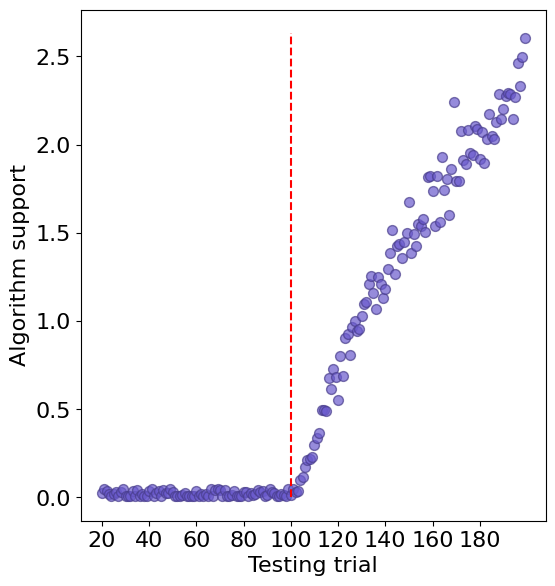

In [43]:
coupling = np.squeeze(np.asarray(algorithm_support_fatigue))
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(6, 7))
plt.scatter(np.arange(20, 200, 1), coupling, color="slateblue", marker='o', s=50, edgecolors='darkslateblue', alpha=0.7 )
plt.xlabel('Testing trial')
plt.ylabel('Algorithm support')
plt.xticks(np.arange(20, 200, 20))
plt.subplots_adjust(bottom=0.15)
plt.vlines(100, 0, max(coupling)*1.01, colors='r', linestyles='dashed', label='Fatigue starts')